In [ ]:
import networkx as nx
import geopy.distance
import csv
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

Processing US States distance data

In [ ]:
# US States Lat and Long
file_path ='states.csv'
max_weight = -1
def read_state_coordinates(file_path):
    state_coordinates = {}
    with open(file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            state = row['state']
            latitude = float(row['latitude'])
            longitude = float(row['longitude'])
            state_coordinates[state] = (latitude, longitude)
    return state_coordinates

In [ ]:
state_coordinates = read_state_coordinates(file_path)

In [ ]:
G = nx.Graph()

In [ ]:
for state in state_coordinates:
    G.add_node(state)

In [ ]:
for state1 in state_coordinates:
    for state2 in state_coordinates:
        if state1 != state2:
            coord1 = state_coordinates[state1]
            coord2 = state_coordinates[state2]
            distance = geopy.distance.distance(coord1, coord2).miles
            max_weight = max(max_weight, distance)
            G.add_edge(state1, state2, weight=distance)

Creating LTM Model

In [ ]:
random.seed(27)

In [ ]:
thresholds = {node: random.uniform(0, 1) for node in G.nodes()}

In [ ]:
initial_active_nodes = random.sample(G.nodes(), int(0.1 * len(G.nodes())))
active_nodes = set(initial_active_nodes)

<ipython-input-9-30aab6d99505>:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_active_nodes = random.sample(G.nodes(), int(0.1 * len(G.nodes())))


In [ ]:
def spread_influence(G, active_nodes, thresholds):
    new_active_nodes = set()
    for node in G.nodes():
        if node not in active_nodes:
            neighbors = G[node]
            active_neighbor_weight = sum(G[node][nbr]['weight'] for nbr in neighbors if nbr in active_nodes)
            total_neighbor_weight = sum(G[node][nbr]['weight'] for nbr in neighbors)
            if total_neighbor_weight > 0 and (active_neighbor_weight / total_neighbor_weight) >= thresholds[node]:
                new_active_nodes.add(node)
    active_nodes.update(new_active_nodes)
    return new_active_nodes

In [ ]:
while True:
    new_activated = spread_influence(G, active_nodes, thresholds)
    if not new_activated:
        break

Plotting LTM Model

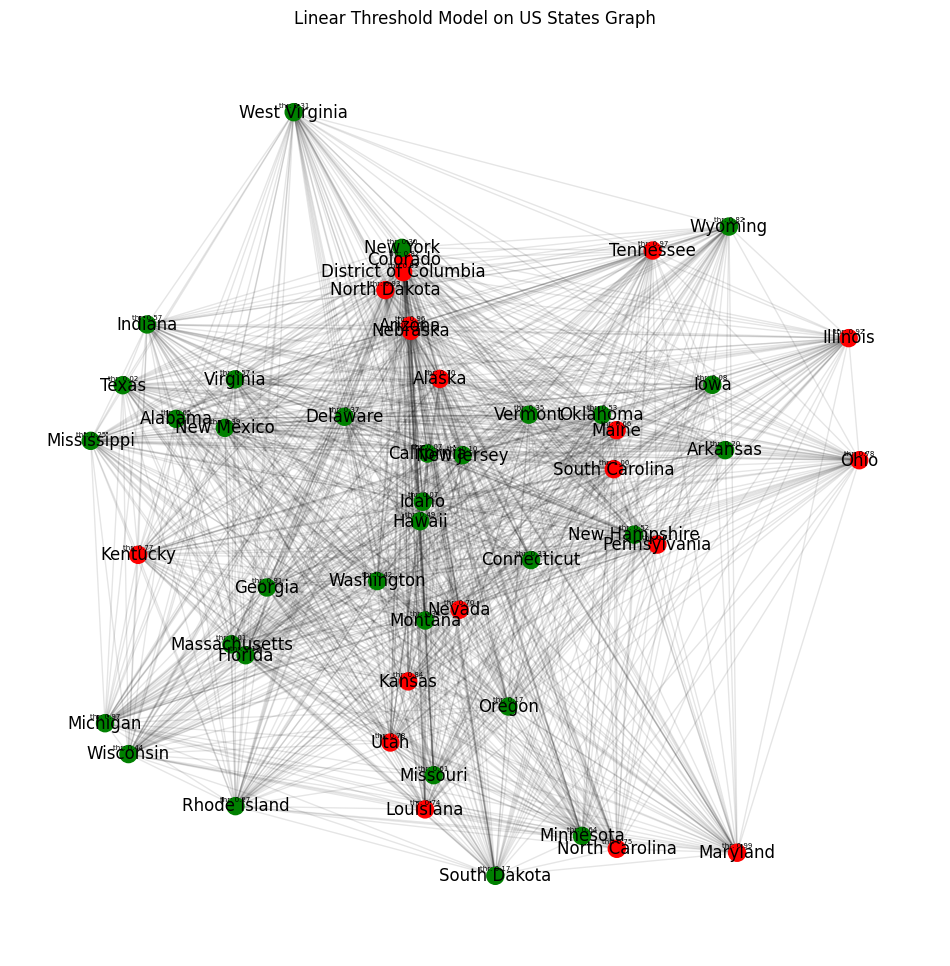

In [ ]:
node_colors = ['green' if node in active_nodes else 'red' for node in G.nodes()]


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=150)
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)

for node in G.nodes():
    plt.text(pos[node][0], pos[node][1]+0.01,
             s=f'thr: {thresholds[node]:.2f}',
             horizontalalignment='center',
             fontdict={'size': 5})

plt.title("Linear Threshold Model on US States Graph")
plt.axis('off')
plt.show()

Processing US States Covid Data

In [ ]:
file_path = 'states_covid_data.csv'
df = pd.read_csv(file_path)
df.head

<bound method NDFrame.head of       date_updated state  start_date    end_date  tot_cases  new_cases  \
0       02/23/2023    AZ  02/16/2023  02/22/2023    2434631       3716   
1       12/22/2022    LA  12/15/2022  12/21/2022    1507707       4041   
2       02/23/2023    GA  02/16/2023  02/22/2023    3061141       5298   
3       03/30/2023    LA  03/23/2023  03/29/2023    1588259       2203   
4       02/02/2023    LA  01/26/2023  02/01/2023    1548508       5725   
...            ...   ...         ...         ...        ...        ...   
10375   04/13/2023    WY  04/06/2023  04/12/2023     186284        158   
10376   04/20/2023    WY  04/13/2023  04/19/2023     186399        115   
10377   04/27/2023    WY  04/20/2023  04/26/2023     186539        140   
10378   05/04/2023    WY  04/27/2023  05/03/2023     186668        129   
10379   02/02/2023    NV  01/26/2023  02/01/2023     884178       1269   

       tot_deaths  new_deaths  new_historic_cases  new_historic_deaths  
0       

In [ ]:
df.head

<bound method NDFrame.head of       date_updated state  start_date    end_date  tot_cases  new_cases  \
0       02/23/2023    AZ  02/16/2023  02/22/2023    2434631       3716   
1       12/22/2022    LA  12/15/2022  12/21/2022    1507707       4041   
2       02/23/2023    GA  02/16/2023  02/22/2023    3061141       5298   
3       03/30/2023    LA  03/23/2023  03/29/2023    1588259       2203   
4       02/02/2023    LA  01/26/2023  02/01/2023    1548508       5725   
...            ...   ...         ...         ...        ...        ...   
10375   04/13/2023    WY  04/06/2023  04/12/2023     186284        158   
10376   04/20/2023    WY  04/13/2023  04/19/2023     186399        115   
10377   04/27/2023    WY  04/20/2023  04/26/2023     186539        140   
10378   05/04/2023    WY  04/27/2023  05/03/2023     186668        129   
10379   02/02/2023    NV  01/26/2023  02/01/2023     884178       1269   

       tot_deaths  new_deaths  new_historic_cases  new_historic_deaths  
0       

Creating National Data by agregating state data

In [ ]:
national_data = df.groupby('date_updated').agg({
    'new_cases': 'sum',
    'new_deaths': 'sum',
    'tot_cases': 'sum',
    'tot_deaths': 'sum'
}).reset_index()

national_data['date_updated'] = pd.to_datetime(national_data['date_updated'])
national_data = national_data.sort_values(by="date_updated").reset_index()

national_data['I'] = 0
national_data['R'] = 0

prev = {}

for i, row in national_data.iterrows():
    I = 0
    R = 0
    if 'I' in prev and 'R' in prev:
        I = prev['I'] + row['new_cases'] - row['new_deaths']
        R = prev['R'] + row['new_deaths']
        national_data.at[i, 'I'] = I
        national_data.at[i, 'R'] = R
    prev['I'] = I
    prev['R'] = R

# Normalizing
national_data['I'] /= 330_000_000
national_data['R'] /= 330_000_000

national_data = national_data.drop(['tot_cases', 'tot_deaths'],axis=1)


In [ ]:
national_data.head

<bound method NDFrame.head of      index date_updated  new_cases  new_deaths             I         R
0        9   2020-01-23          6           0  0.000000e+00  0.000000
1       13   2020-01-30          5           0  1.515152e-08  0.000000
2       17   2020-02-06         12           0  5.151515e-08  0.000000
3       21   2020-02-13         13           0  9.090909e-08  0.000000
4       25   2020-02-20         16           0  1.393939e-07  0.000000
..     ...          ...        ...         ...           ...       ...
168     54   2023-04-13     110152        1287  3.126227e-01  0.003414
169     58   2023-04-20     106903        1224  3.129429e-01  0.003418
170     62   2023-04-27      96470        1087  3.132320e-01  0.003421
171     66   2023-05-04      85699        1092  3.134884e-01  0.003425
172     70   2023-05-11      76233         872  3.137167e-01  0.003427

[173 rows x 6 columns]>

Creating a train/test split of 80-20

In [ ]:
train, test = train_test_split(national_data, test_size=0.2, shuffle=False)

In [ ]:
def si_model(y, t, N, beta, gamma):
    S, I = y
    dSdt = -beta * S * I + gamma * I
    dIdt = beta * S * I - gamma * I
    return dSdt, dIdt #, dRdt

In [ ]:
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [ ]:
def sirs_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I + gamma * I * 0.964
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I * 0.036
    return dSdt, dIdt, dRdt

In [ ]:
def total_loss(params, data, S0, I0, N, R0=None):
    beta, gamma = params
    t = np.arange(len(data))
    y0 = (S0, I0) if R0 is None else (S0, I0, R0)
    solution = odeint(si_model if R0 is None else sir_model, y0, t, args=(N, beta, gamma))
    I_predicted = solution[:, 1]
    I_actual = data[:, 0]



    # Calculate the loss (e.g., sum of squared differences) for I and R
    loss_I = np.sum((I_actual - I_predicted) ** 2)

    if R0 is not None:
      R_actual = data[:, 1]
      R_predicted = solution[:, 2]
      loss_R = np.sum((R_actual - R_predicted) ** 2)
    else:
      loss_R = 0

    # Total loss is the sum of individual losses
    return loss_I + loss_R

In [ ]:
# Initial conditions for SI model
N = 1.0
I0 = train['I'].iloc[1]
S0 = N - I0

I0


1.5151515151515152e-08

In [ ]:
data = np.array([
    train['I']
    #train['R']
]).T


Running minimize to find params that minimize loss

In [ ]:
initial_params = [0.05, 0.05]  # Initial guess
optimal = minimize(total_loss, initial_params, args=(data, S0, I0, N))
beta, gamma = optimal.x

print(beta)
print(gamma)

0.8528271153531665
0.6562272311747075


In [ ]:
validation_data = np.array([
    test['I']
]).T


In [ ]:
t = np.arange(len(national_data))
solution = odeint(si_model, (S0, I0), t, args=(N, beta, gamma))


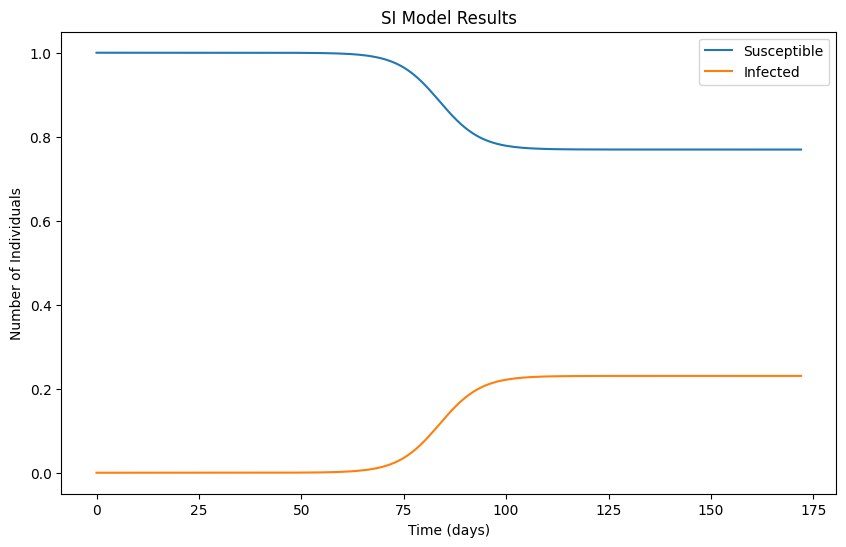

In [ ]:
S, I = solution.T
t = np.arange(len(solution))

plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
#plt.plot(t, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Number of Individuals')
plt.title('SI Model Results')
plt.legend()
plt.show()

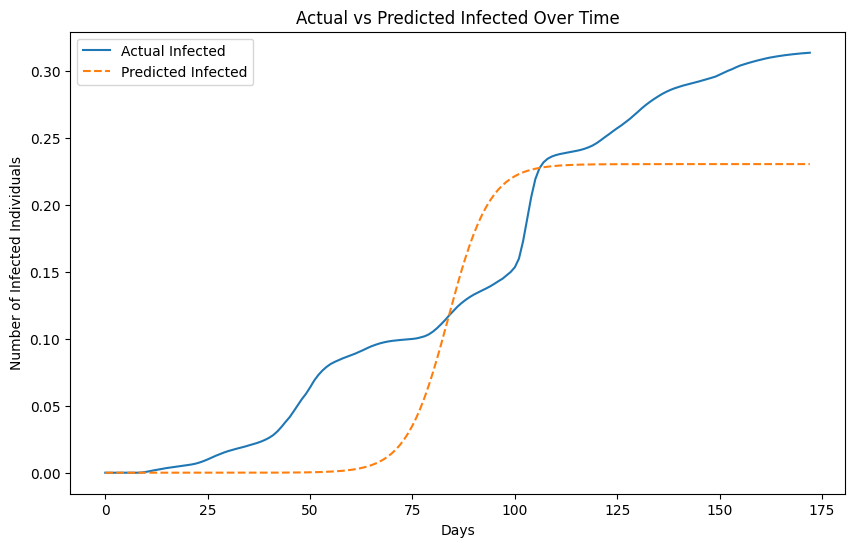

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(actual_infected.index, actual_infected, label='Actual Infected')
plt.plot(actual_infected.index, predicted_infected, label='Predicted Infected', linestyle='dashed')
plt.xlabel('Days')
plt.ylabel('Number of Infected Individuals')
plt.title('Actual vs Predicted Infected Over Time')
plt.legend()
plt.show()

SI MSE

In [ ]:
loss = np.sum((actual_infected - I) ** 2)

loss/len(national_data)

0.002717222840254921

In [ ]:
# SIR Initial conditions
N = 1.0
I0 = train['I'].iloc[1]
S0 = N - I0
R0 = 0

I0

1.5151515151515152e-08

In [ ]:
data = np.array([
    train['I'],
    train['R'],
]).T


In [ ]:
initial_params = [0.12, 0.12]  # Initial guess
optimal = minimize(total_loss, initial_params, args=(data, S0, I0, N, R0))
beta, gamma = optimal.x

print(beta)
print(gamma)

0.18646756530375017
0.05431903310221135


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-20-505124120c51>:12: RuntimeWarning: overflow encountered in square
  loss_I = np.sum((I_actual - I_predicted) ** 2)
<ipython-input-20-505124120c51>:17: RuntimeWarning: overflow encountered in square
  loss_R = np.sum((R_actual - R_predicted) ** 2)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [ ]:
validation_data = np.array([
    test['I'],
    test['R'],
]).T


In [ ]:
t = np.arange(len(national_data))
solution = odeint(sir_model, (S0, I0, R0), t, args=(N, beta, gamma))


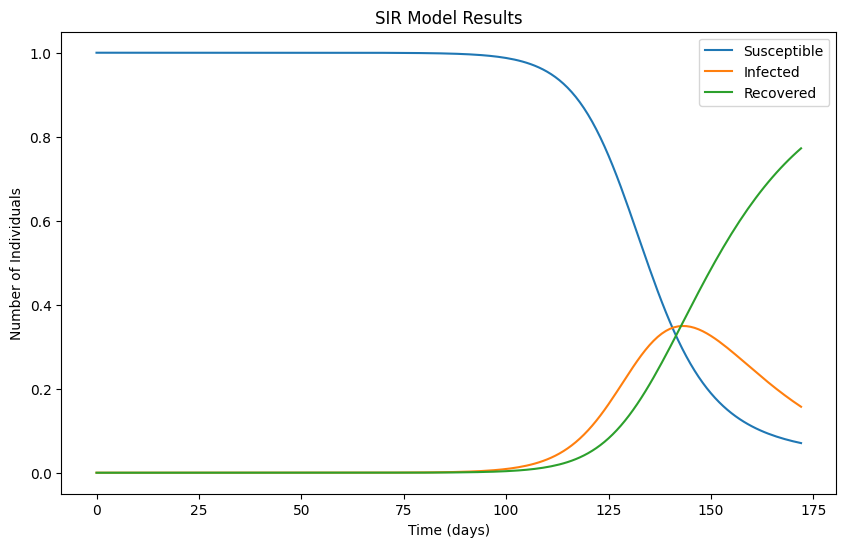

In [ ]:
S, I, R = solution.T
t = np.arange(len(solution))

plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Number of Individuals')
plt.title('SIR Model Results')
plt.legend()
plt.show()

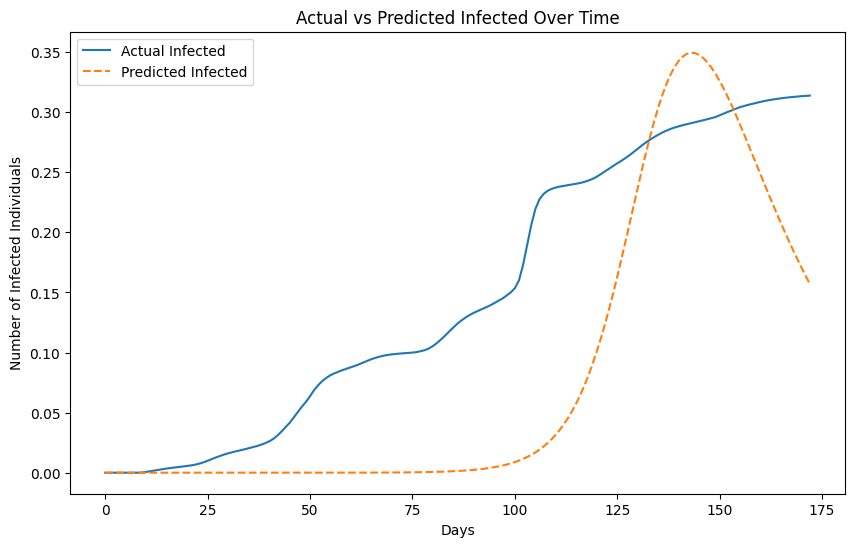

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(actual_infected.index, actual_infected, label='Actual Infected')
plt.plot(actual_infected.index, predicted_infected, label='Predicted Infected', linestyle='dashed')
plt.xlabel('Days')
plt.ylabel('Number of Infected Individuals')
plt.title('Actual vs Predicted Infected Over Time')
plt.legend()
plt.show()

SIR MSE

In [ ]:
loss = np.sum((actual_infected - I) ** 2)

loss/len(national_data)

0.00930294313069018

In [ ]:
N = 1.0
I0 = train['I'].iloc[1]
S0 = N - I0
R0 = 0

I0

1.5151515151515152e-08

In [ ]:
data = np.array([
    train['I'],
    train['R'],
]).T


In [ ]:
initial_params = [0.1, 0.1]  # Initial guess
optimal = minimize(total_loss, initial_params, args=(data, S0, I0, N, R0))
beta, gamma = optimal.x

print(beta)
print(gamma)

0.1671209824628986
0.033804568867257204


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [ ]:
validation_data = np.array([
    test['I'],
    test['R'],
]).T


In [ ]:
t = np.arange(len(national_data))
beta = 0.495
gamma = 0.29
solution = odeint(sirs_model, (S0, I0, R0), t, args=(N, beta, gamma))


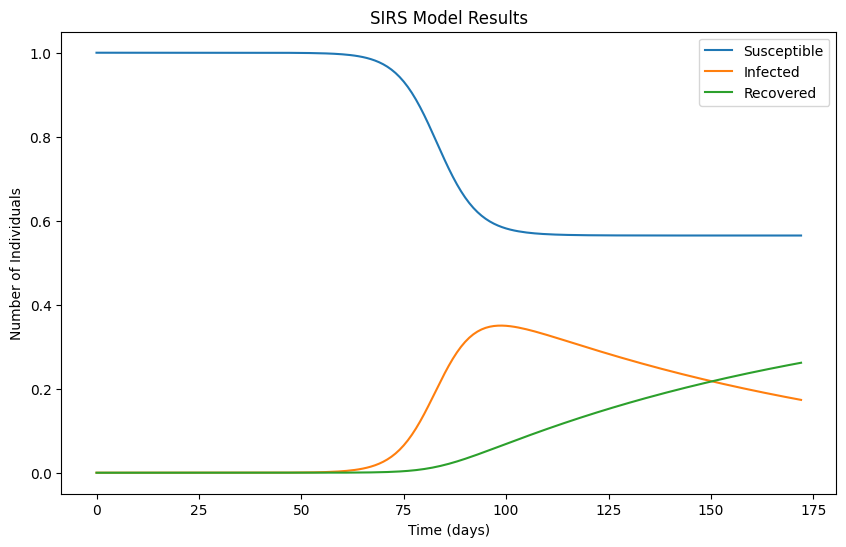

In [ ]:
S, I, R = solution.T
t = np.arange(len(solution))

plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Number of Individuals')
plt.title('SIRS Model Results')
plt.legend()
plt.show()

In [ ]:
actual_infected = national_data['I']
predicted_infected = solution[:, 1]

predicted_infected.shape

(173,)

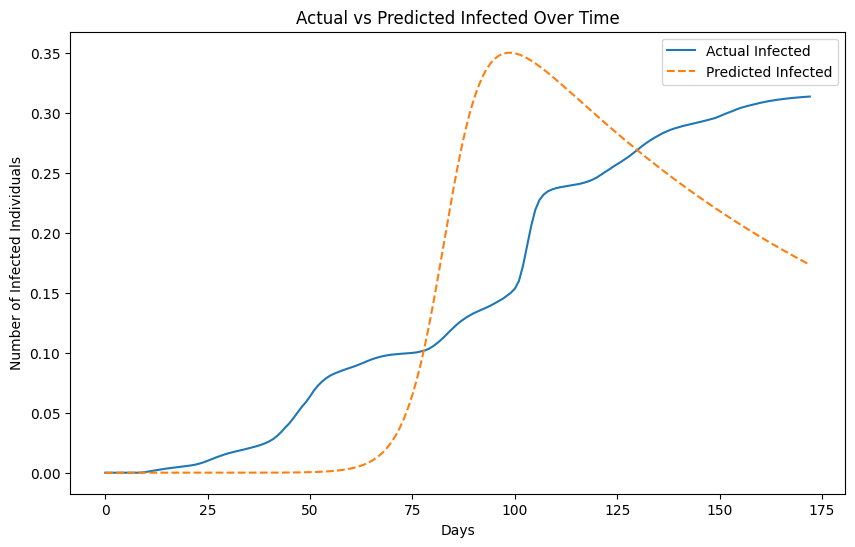

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(actual_infected.index, actual_infected, label='Actual Infected')
plt.plot(actual_infected.index, predicted_infected, label='Predicted Infected', linestyle='dashed')
plt.xlabel('Days')
plt.ylabel('Number of Infected Individuals')
plt.title('Actual vs Predicted Infected Over Time')
plt.legend()
plt.show()

SIRS MSE

In [ ]:
loss = np.sum((actual_infected - I) ** 2)

loss/len(national_data)

0.007569098100529872

In [ ]:
active_nodes

{'Alabama',
 'Arkansas',
 'California',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Indiana',
 'Iowa',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'Oklahoma',
 'Oregon',
 'Rhode Island',
 'South Dakota',
 'Texas',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming'}

In [ ]:
def graph_sirs_simulation(G, base_beta, gamma, initial_infected, active_nodes, steps):
    # Initialize states: 0 for Susceptible, 1 for Infected, 2 for Recovered
    nx.set_node_attributes(G, 0, 'state')
    for node in initial_infected:
        G.nodes[node]['state'] = 1

    history = []

    for _ in range(steps):
        new_state = {node: {'S': G.nodes[node]['S'], 'I': G.nodes[node]['I'], 'R': G.nodes[node]['R']} for node in G.nodes()}
        for node in G.nodes():
            if G.nodes[node]['I'] > 0:
                # Infection spread to neighbors
                for neighbor in G.neighbors(node):
                    if G.nodes[neighbor]['S'] > 0:
                        edge_weight = G[node][neighbor].get('weight', 1)
                        weight_factor = 1 - (edge_weight / max_weight)
                        active_factor = 3 if node in active_nodes else 0.4
                        infection_chance = base_beta * weight_factor * active_factor * G.nodes[node]['I']
                        new_infected = infection_chance * G.nodes[neighbor]['S']
                        new_state[neighbor]['S'] -= new_infected
                        new_state[neighbor]['I'] += new_infected
                # Recovery
                recovered = gamma * G.nodes[node]['I']
                new_state[node]['I'] -= recovered
                new_state[node]['S'] += 0.966*recovered
                new_state[node]['R'] += 0.044*recovered
        # Update states
        for node in G.nodes():
          G.nodes[node].update(new_state[node])
        total_infected = sum([G.nodes[node]['I'] for node in G.nodes()])
        total_recovered = sum([G.nodes[node]['R'] for node in G.nodes()])
        total_susceptible = sum([G.nodes[node]['S'] for node in G.nodes()])
        history.append({'I': total_infected, 'R': total_recovered, 'S': total_susceptible})

    return history


In [ ]:
node_population = N / len(G.nodes())

# Initialize each node's S, I, R states
for node in G.nodes():
    G.nodes[node]['S'] = node_population - 1e-5
    G.nodes[node]['I'] = 1e-5
    G.nodes[node]['R'] = 0

# base_beta = 0.05
# gamma = 0.03
# SI Graph beta, gamma
base_beta = 0.105
gamma = 0.094


infection_history = graph_sirs_simulation(G, base_beta, gamma, list(active_nodes)[:5], active_nodes, len(national_data))

In [ ]:
S = [state['S'] for state in infection_history]
I = [state['I'] for state in infection_history]
R = [state['R'] for state in infection_history]

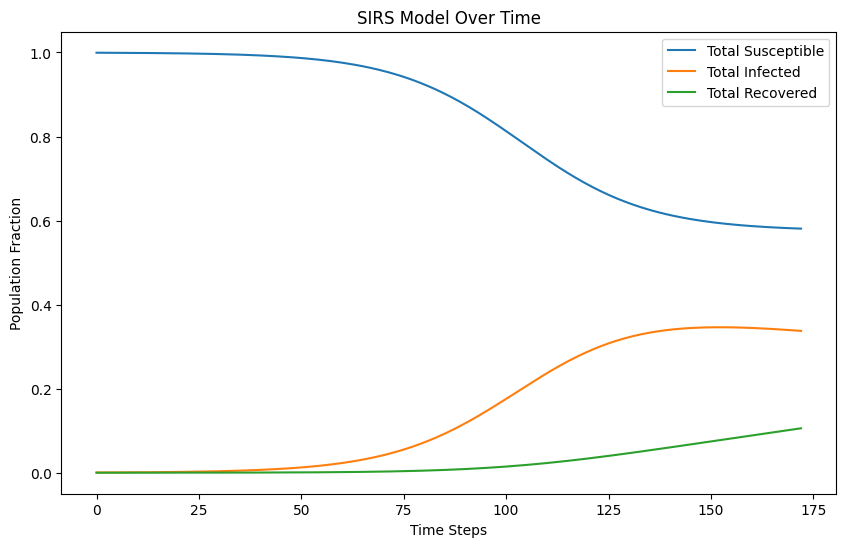

In [ ]:
t = range(len(infection_history))

# Plotting the SIR curves
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Total Susceptible')
plt.plot(t, I, label='Total Infected')
plt.plot(t, R, label='Total Recovered')
plt.xlabel('Time Steps')
plt.ylabel('Population Fraction')
plt.title('SIRS Model Over Time')
plt.legend()
plt.show()

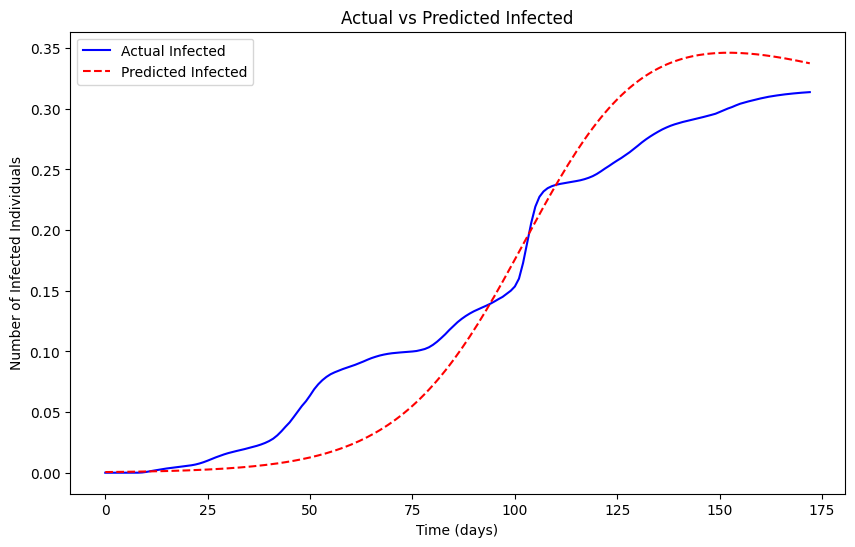

In [ ]:
actual_infected = national_data['I']

plt.figure(figsize=(10, 6))
plt.plot(t, actual_infected, label='Actual Infected', color='blue')
plt.plot(t, I, label='Predicted Infected', color='red', linestyle='dashed')
plt.xlabel('Time (days)')
plt.ylabel('Number of Infected Individuals')
plt.title('Actual vs Predicted Infected')
plt.legend()
plt.show()


In [ ]:
loss = np.sum((actual_infected - I)**2)

loss/len(national_data)

0.0013757593039562806

In [ ]:
def graph_si_simulation(G, base_beta, gamma, initial_infected, active_nodes, steps):
    # Initialize states: 0 for Susceptible, 1 for Infected, 2 for Recovered
    nx.set_node_attributes(G, 0, 'state')
    for node in initial_infected:
        G.nodes[node]['state'] = 1

    history = []

    for _ in range(steps):
        new_state = {node: {'S': G.nodes[node]['S'], 'I': G.nodes[node]['I'], 'R': G.nodes[node]['R']} for node in G.nodes()}
        for node in G.nodes():
            if G.nodes[node]['I'] > 0:  # Infected nodes
                # Infection spread to neighbors
                for neighbor in G.neighbors(node):
                    if G.nodes[neighbor]['S'] > 0:  # Susceptible neighbors
                        edge_weight = G[node][neighbor].get('weight', 1)
                        weight_factor = 1 - (edge_weight / max_weight)
                        active_factor = 3 if node in active_nodes else 0.4
                        infection_chance = base_beta * weight_factor * active_factor * G.nodes[node]['I']
                        new_infected = infection_chance * G.nodes[neighbor]['S']
                        new_state[neighbor]['S'] -= new_infected
                        new_state[neighbor]['I'] += new_infected
                        # print(new_state[neighbor]['I'])
                # Recovery
                recovered = gamma * G.nodes[node]['I']
                new_state[node]['I'] -= recovered
                new_state[node]['S'] += recovered
        # Update states
        for node in G.nodes():
          G.nodes[node].update(new_state[node])
        total_infected = sum([G.nodes[node]['I'] for node in G.nodes()])
        total_recovered = sum([G.nodes[node]['R'] for node in G.nodes()])
        total_susceptible = sum([G.nodes[node]['S'] for node in G.nodes()])
        history.append({'I': total_infected, 'R': total_recovered, 'S': total_susceptible})

    return history


In [ ]:
node_population = N / len(G.nodes())

# Initialize each node's S, I, R states
for node in G.nodes():
    G.nodes[node]['S'] = node_population - 1e-5
    G.nodes[node]['I'] = 1e-5
    G.nodes[node]['R'] = 0

# base_beta = 0.05
# gamma = 0.03
# SI Graph beta, gamma
base_beta = 0.1
gamma = 0.094


infection_history = graph_si_simulation(G, base_beta, gamma, list(active_nodes)[:3], active_nodes, len(national_data))

In [ ]:
S = [state['S'] for state in infection_history]
I = [state['I'] for state in infection_history]
R = [state['R'] for state in infection_history]

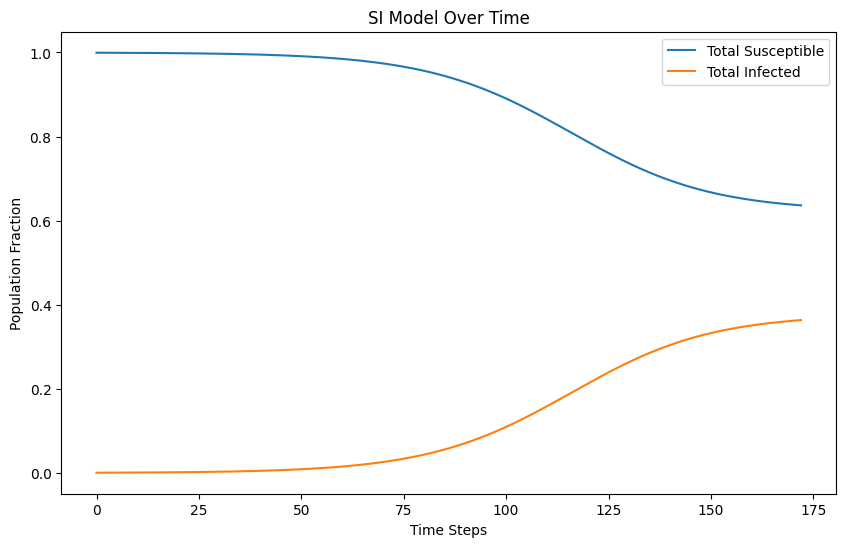

In [ ]:
t = range(len(infection_history))

# Plotting the SIR curves
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Total Susceptible')
plt.plot(t, I, label='Total Infected')
#plt.plot(t, R, label='Total Recovered')
plt.xlabel('Time Steps')
plt.ylabel('Population Fraction')
plt.title('SI Model Over Time')
plt.legend()
plt.show()

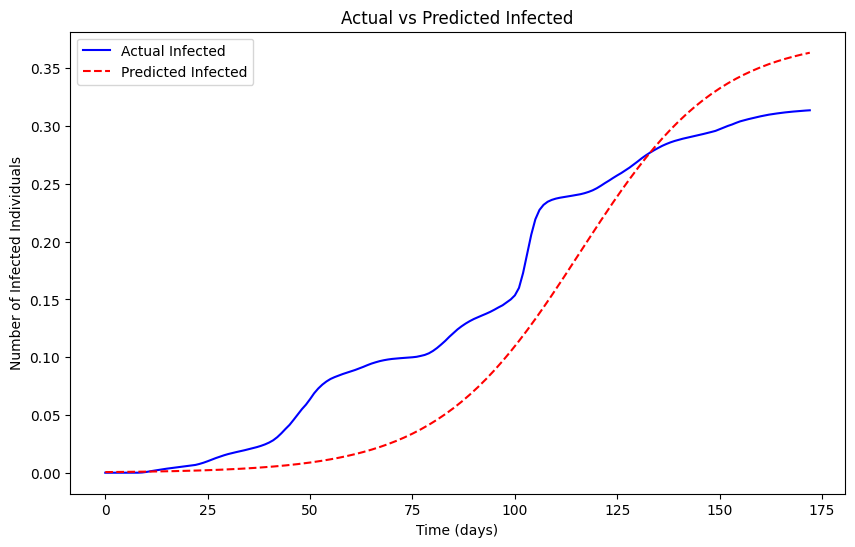

In [ ]:
actual_infected = national_data['I']

plt.figure(figsize=(10, 6))
plt.plot(t, actual_infected, label='Actual Infected', color='blue')
plt.plot(t, I, label='Predicted Infected', color='red', linestyle='dashed')
plt.xlabel('Time (days)')
plt.ylabel('Number of Infected Individuals')
plt.title('Actual vs Predicted Infected')
plt.legend()
plt.show()


In [ ]:
loss = np.sum((actual_infected - I)**2)

loss/len(national_data)

0.002164861713617437

In [ ]:
def graph_sir_simulation(G, base_beta, gamma, initial_infected, active_nodes, steps):
    # Initialize states: 0 for Susceptible, 1 for Infected, 2 for Recovered
    nx.set_node_attributes(G, 0, 'state')
    for node in initial_infected:
        G.nodes[node]['state'] = 1

    history = []

    for _ in range(steps):
        new_state = {node: {'S': G.nodes[node]['S'], 'I': G.nodes[node]['I'], 'R': G.nodes[node]['R']} for node in G.nodes()}
        for node in G.nodes():
            if G.nodes[node]['I'] > 0:  # Infected nodes
                # Infection spread to neighbors
                for neighbor in G.neighbors(node):
                    if G.nodes[neighbor]['S'] > 0:  # Susceptible neighbors
                        edge_weight = G[node][neighbor].get('weight', 1)
                        weight_factor = 1 - (edge_weight / max_weight)
                        active_factor = 3 if node in active_nodes else 0.4
                        infection_chance = base_beta * weight_factor * active_factor * G.nodes[node]['I']
                        new_infected = infection_chance * G.nodes[neighbor]['S']
                        new_state[neighbor]['S'] -= new_infected
                        new_state[neighbor]['I'] += new_infected
                        # print(new_state[neighbor]['I'])
                # Recovery
                recovered = gamma * G.nodes[node]['I']
                new_state[node]['I'] -= recovered
                new_state[node]['R'] += recovered
        # Update states
        for node in G.nodes():
          G.nodes[node].update(new_state[node])
        total_infected = sum([G.nodes[node]['I'] for node in G.nodes()])
        total_recovered = sum([G.nodes[node]['R'] for node in G.nodes()])
        total_susceptible = sum([G.nodes[node]['S'] for node in G.nodes()])
        history.append({'I': total_infected, 'R': total_recovered, 'S': total_susceptible})

    return history


In [ ]:
node_population = N / len(G.nodes())

# Initialize each node's S, I, R states
for node in G.nodes():
    G.nodes[node]['S'] = node_population - 1e-5
    G.nodes[node]['I'] = 1e-5
    G.nodes[node]['R'] = 0

# base_beta = 0.05
# gamma = 0.03
# SI Graph beta, gamma
base_beta = 0.06
gamma = 0.019


infection_history = graph_sir_simulation(G, base_beta, gamma, list(active_nodes)[:3], active_nodes, len(national_data))

In [ ]:
S = [state['S'] for state in infection_history]
I = [state['I'] for state in infection_history]
R = [state['R'] for state in infection_history]

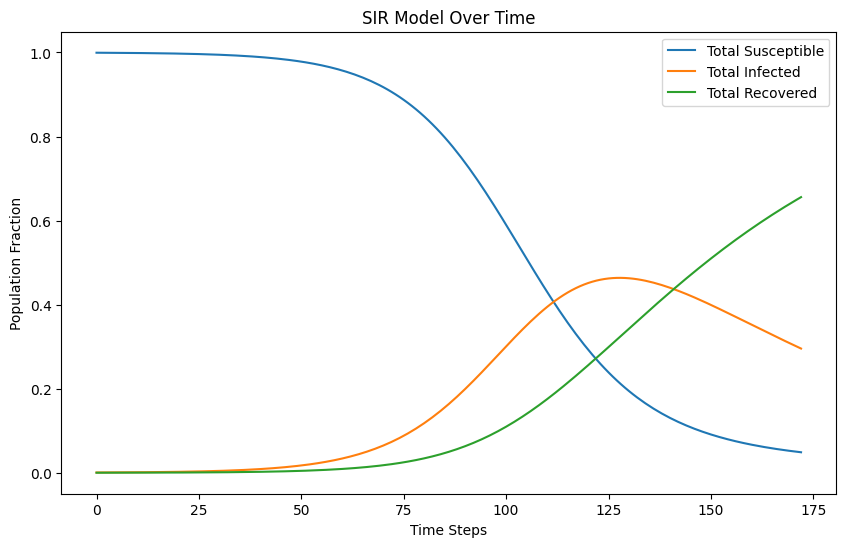

In [ ]:
t = range(len(infection_history))

# Plotting the SIR curves
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Total Susceptible')
plt.plot(t, I, label='Total Infected')
plt.plot(t, R, label='Total Recovered')
plt.xlabel('Time Steps')
plt.ylabel('Population Fraction')
plt.title('SIR Model Over Time')
plt.legend()
plt.show()

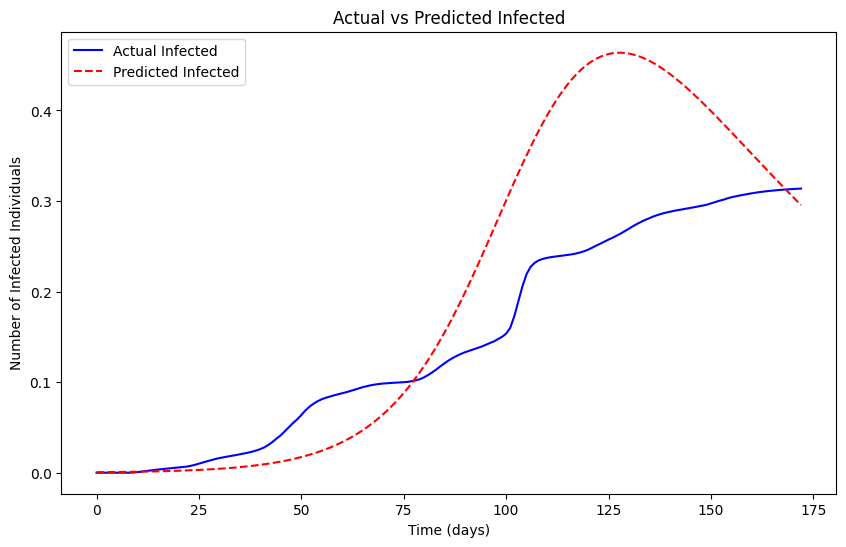

In [ ]:
actual_infected = national_data['I']

plt.figure(figsize=(10, 6))
plt.plot(t, actual_infected, label='Actual Infected', color='blue')
plt.plot(t, I, label='Predicted Infected', color='red', linestyle='dashed')
plt.xlabel('Time (days)')
plt.ylabel('Number of Infected Individuals')
plt.title('Actual vs Predicted Infected')
plt.legend()
plt.show()


In [ ]:
loss = np.sum((actual_infected - I)**2)

loss/len(national_data)

0.009799485192198708